# Can figure out substrate uptake hierarchy without running the whole simulation

# Match individual growth rates first
# Using coarse model

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['svg.fonttype'] = 'none'
pd.set_option('display.max_colwidth', -1)
%matplotlib inline

In [2]:
PROTOTYPE = False

In [3]:
from dynamicme.tests.helpme import HelpME
from dynamicme.dynamic import get_cplx_concs

helper = HelpME(prototyping=PROTOTYPE)
solver = helper.solver
me = solver.me

## Change keffs until uptake hierarchy correct

In [4]:
import numpy as np

df_dh = pd.read_csv('/home/laurence/ME/data/DHeckmann/kappmax_rf_dl_iJO.csv')

import re
from cobra.io import load_json_model

ijo = load_json_model('/home/laurence/ME/models/BiGG_M/json/iJO1366.json')

rows = []
biggids = df_dh['bigg.id'].apply(lambda x: re.sub(r'(_[b|f]$)', '',x)).unique()
missed = []
for biggid in biggids:
    try:
        sdata = me.stoichiometric_data.get_by_id(biggid)
        mrxn = ijo.reactions.get_by_id(biggid)
        rname = mrxn.name        
        for rxn in sdata.parent_reactions:
            mmol_gDW = rxn.x / rxn.keff / 3600
            rows.append({'bigg_id':biggid, 'rxn':rxn.id, 'name':rname, 'keff_nominal':rxn.keff, 'subsystem':mrxn.subsystem, 'reaction':mrxn.reaction, 'mmol_gDW':mmol_gDW})
    except KeyError:
        missed.append(biggid)
        
df_rmap = pd.DataFrame(rows)
        
print 'biggids not mapped:', len(missed)

biggids not mapped: 252


In [5]:
print 'Subsystems:', len(df_rmap.subsystem.unique())
print 'Rxns within alternate carbon metab:', len(df_rmap.rxn[ df_rmap.subsystem=='Alternate Carbon Metabolism'])

ProtM = df_rmap.mmol_gDW.sum()
print 'Expressed protein (mmol/gDW):', ProtM

Subsystems: 35
Rxns within alternate carbon metab: 285
Expressed protein (mmol/gDW): 0.00495155284852


In [6]:
%%time

KEFF_SCALE = 0.32

from cobra import Metabolite, Reaction

ijomc = load_json_model('/home/laurence/ME/models/BiGG_M/json/iJO1366.json')

cons_crowding = Metabolite('crowding')
ijomc.add_metabolites([cons_crowding])

# sum_j v/keff  <= P [mmol/gDW]

for rid in df_rmap.bigg_id.unique():
    #row = df_rmap[ df_rmap.bigg_id==rid].iloc[0]
    dfi = df_rmap[ df_rmap.bigg_id==rid]
    #if dfi.shape[0]>1:
        #print dfi['keff_nominal'].tolist()
        #dfk = dfi.copy()
    keff_nom = dfi['keff_nominal'].mean()
    rxn = ijomc.reactions.get_by_id(rid)
    if rxn.lower_bound < 0:
        rxn_abs = Reaction(rxn.id + '_abs')
        ijomc.add_reaction(rxn_abs)
        # rabs >= r  :  rabs - r >= 0
        # rabs >= -r :  rabs + r >= 0        
        cons_abs_p = Metabolite('cons_'+rxn.id+'_abs_p')
        cons_abs_n = Metabolite('cons_'+rxn.id+'_abs_n')
        cons_abs_p._constraint_sense = 'G'
        cons_abs_n._constraint_sense = 'G'
        rxn_abs.add_metabolites({cons_abs_p: 1., cons_abs_n: 1.})
        rxn.add_metabolites({cons_abs_p:-1., cons_abs_n:1.})
        keff = keff_nom * KEFF_SCALE
        rxn_abs.add_metabolites({cons_crowding:1./keff/3600 })
    else:
        rxn.add_metabolites({cons_crowding:1./keff_nom/3600})

cons_crowding._constraint_sense = 'L'
cons_crowding._bound = ProtM

CPU times: user 1.64 s, sys: 13.3 ms, total: 1.65 s
Wall time: 1.65 s


In [7]:
ijomc.optimize(solver='gurobi')

<Solution 0.74 at 0x7f97dee79150>

In [8]:
df_meas = pd.read_csv('/home/laurence/ME/data/dynamicME/beg/growth_meas.csv')

In [9]:
rank_meas = {'EX_ac_e': 5,
             'EX_gal_e': 2,
             'EX_glc__D_e': 0,
             'EX_glyc_e': 4,
             'EX_lac__L_e': 1,
             'EX_malt_e': 3
            }    

In [10]:
%%time

mrows = []
ZERO = 1e-8

for ex_id in rank_meas.keys():
    # Reset first
    for rid in rank_meas.keys():
        rxn = ijomc.reactions.get_by_id(rid)
        rxn.lower_bound = 0.
    rxn = ijomc.reactions.get_by_id(ex_id)
    rxn.lower_bound = -10
    ijomc.optimize()
    mmu = ijomc.reactions.BIOMASS_Ec_iJO1366_core_53p95M.x
    # Was the MC constraint active?
    tot_prot = sum([r.x*r.metabolites[cons_crowding] for r in cons_crowding.reactions])
    mrows.append({'muopt':mmu, 'ex_rxn':ex_id, 'tot_prot':tot_prot, 'crowding_active':abs(cons_crowding._bound - tot_prot)<ZERO})

CPU times: user 2.66 s, sys: 3.33 ms, total: 2.67 s
Wall time: 2.66 s


In [11]:
df_ijo = pd.DataFrame(mrows)

df_ijo.sort_values('muopt')

,crowding_active,ex_rxn,muopt,tot_prot
4,True,EX_ac_e,0.247199,0.004952
2,False,EX_lac__L_e,0.399080,0.003224
0,False,EX_glyc_e,0.562790,0.004466
1,True,EX_gal_e,0.640752,0.004952
5,True,EX_glc__D_e,0.743375,0.004952
3,True,EX_malt_e,0.744083,0.004952


Pearson r=0.936904 (p=0.00584603)
Spearman r=0.942857 (p=0.00480466)


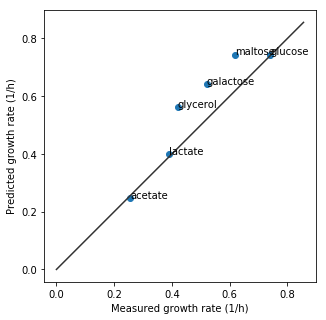

In [12]:
import scipy.stats as stats


#sim_dict = {r['ex_rxn']:r['muopt'] for i,r in df_ijo.iterrows()}
#rxns_sorted = sorted([s[1] for s in sims], key=lambda x: sim_dict[x], reverse=True)
#substrates = rank_meas.keys()
#rank_pred = {k: rxns_sorted.index(k) for k in substrates}
#r_meas = [rank_meas[k] for k in substrates]
#r_pred = [rxns_sorted.index(k) for k in substrates]
# r_meas = rank_meas.values()
df_val = pd.merge(df_ijo, df_meas, on='ex_rxn')
xymax = max(df_val.growth_rate_1_h.max(), df_val.muopt.max())
plt.plot([0, xymax*1.15], [0, xymax*1.15], color='#333333')
plt.scatter(df_val.growth_rate_1_h, df_val.muopt)
#for k in substrates:
for i,r in df_val.iterrows():
    x = r['growth_rate_1_h']
    y = r['muopt']
    k = r['substrate']
    ls = plt.text(x, y, k)
ax = ls.axes
ax.set_aspect(1)
ax.figure.set_size_inches(5,5)
ax.set_xlabel('Measured growth rate (1/h)')
ax.set_ylabel('Predicted growth rate (1/h)')
# ax.set_xlabel('Measured rank')
# ax.set_ylabel('Predicted rank')

r,p = stats.pearsonr(df_val.growth_rate_1_h, df_val.muopt)
print 'Pearson r=%g (p=%g)' % (r,p)
r,p = stats.spearmanr(df_val.growth_rate_1_h, df_val.muopt)
print 'Spearman r=%g (p=%g)' % (r,p)
#r,p = stats.pearsonr(r_meas, r_pred)
#print 'r=%g (p=%g)' % (r,p)

# Metaheuristics on small model to get growth rates right

In [13]:
rank_meas

{'EX_ac_e': 5,
 'EX_gal_e': 2,
 'EX_glc__D_e': 0,
 'EX_glyc_e': 4,
 'EX_lac__L_e': 1,
 'EX_malt_e': 3}

In [14]:
df_exp = df_meas[ df_meas.ex_rxn.isin(rank_meas.keys())]
meas_dict = {r['ex_rxn']:r['growth_rate_1_h'] for i,r in df_exp.iterrows()}

In [15]:
meas_dict

{'EX_ac_e': 0.256,
 'EX_gal_e': 0.52,
 'EX_glc__D_e': 0.74,
 'EX_glyc_e': 0.42,
 'EX_lac__L_e': 0.39,
 'EX_malt_e': 0.62}

In [16]:
def sim_fun(mdl):
    mu_id = 'BIOMASS_Ec_iJO1366_core_53p95M'
    sim_dict = {}
    for ex_id in meas_dict.keys():
        # Reset first
        for rid in meas_dict.keys():
            rxn = mdl.reactions.get_by_id(rid)
            rxn.lower_bound = 0.
        rxn = mdl.reactions.get_by_id(ex_id)
        rxn.lower_bound = -10
        mdl.optimize(solver='gurobi')
        if mdl.solution is not None:
            mmu = mdl.reactions.get_by_id(mu_id).x
        else:
            mmu = 0.
        sim_dict[ex_id] = mmu
    
    return sim_dict

In [17]:
def obj_fun(y_sim, y_meas):
    ### Objective function    
    sse = sum([ (y - y_sim[r])**2 for r,y in y_meas.iteritems()]) 
    
    return sse

In [18]:
cons_crowding

<Metabolite crowding at 0x7f97dbab0710>

In [19]:
def get_param_fun(mdl):
    cons_id = 'crowding'
    cons = mdl.metabolites.get_by_id(cons_id)
    params = [r.metabolites[cons] for r in cons.reactions]
    
    return params

def set_param_fun(mdl, params):
    cons_id = 'crowding'
    cons = mdl.metabolites.get_by_id(cons_id)
    for j,rxn in enumerate(cons.reactions):
        rxn._metabolites[cons] = params[j]

In [20]:
from dynamicme.metaopt import MetaOpt

In [21]:
mopt = MetaOpt(ijomc, sim_fun, obj_fun, get_param_fun, set_param_fun)

In [22]:
result = mopt.optimize(meas_dict)

NameError: global name 'y' is not defined

# Simple projection of uptake hierarchy

In [360]:
def calc_uptake_hier(mdl, ex_rxns, mu_id='BIOMASS_Ec_iJO1366_core_53p95M'):
    ZERO = 1e-10
    subs_avail = list(ex_rxns)
    avail = True
    mrows = []        
    niter = 0
    # Open all initially
    for rid in ex_rxns:
        rxn = mdl.reactions.get_by_id(rid)
        rxn.lower_bound = -10.
    while avail:
        print 'subs_avail:', subs_avail
        for rid in ex_rxns:
            if rid not in subs_avail:
                rxn = mdl.reactions.get_by_id(rid)
                rxn.lower_bound = 0.
        mdl.optimize(solver='gurobi')
        
        if mdl.solution is not None:
            mmu = mdl.reactions.get_by_id(mu_id).x
            # Was the MC constraint active?
            tot_prot = sum([r.x*r.metabolites[cons_crowding] for r in cons_crowding.reactions])                
            # Remove uptaken mets
            uptakes = {}
            for rid in ex_rxns:
                rxn = mdl.reactions.get_by_id(rid)
                if rxn.x < -ZERO:
                    print '%s: %g' % (rxn.id, rxn.x)
                    subs_avail.remove(rid)
                    uptakes[rxn.id] = rxn.x
                        
            print 'uptakes:', uptakes      
            mrows.append({'iter':niter, 'muopt':mmu, 'uptakes':uptakes,
                          'tot_prot':tot_prot, 'crowding_active':abs(cons_crowding._bound - tot_prot)<ZERO})        

            if len(subs_avail)==0 or mmu < ZERO:
                avail=False
            print 'Iter %d\t mu: %g\t uptakes:%s' % (niter, mmu, ';'.join(uptakes))
            niter += 1
        else:
            avail = False
        
    df_result = pd.DataFrame(mrows)
    return df_result

In [361]:
df_hier = calc_uptake_hier(ijomc, rank_meas.keys())

subs_avail: ['EX_glyc_e', 'EX_gal_e', 'EX_lac__L_e', 'EX_malt_e', 'EX_ac_e', 'EX_glc__D_e']
EX_glyc_e: -0.105557
EX_lac__L_e: -7.4185
EX_malt_e: -2.4186
uptakes: {u'EX_malt_e': -2.418603263618521, u'EX_glyc_e': -0.10555726032390744, u'EX_lac__L_e': -7.41850363689998}
Iter 0	 mu: 0.759252	 uptakes:EX_malt_e;EX_glyc_e;EX_lac__L_e
subs_avail: ['EX_gal_e', 'EX_ac_e', 'EX_glc__D_e']
EX_glc__D_e: -8.02222
uptakes: {u'EX_glc__D_e': -8.022219083626828}
Iter 1	 mu: 0.738925	 uptakes:EX_glc__D_e
subs_avail: ['EX_gal_e', 'EX_ac_e']
EX_gal_e: -6.54507
uptakes: {u'EX_gal_e': -6.545069052190994}
Iter 2	 mu: 0.605274	 uptakes:EX_gal_e
subs_avail: ['EX_ac_e']
EX_ac_e: -10
uptakes: {u'EX_ac_e': -10.0}
Iter 3	 mu: 0.247199	 uptakes:EX_ac_e


In [362]:
df_hier

,crowding_active,iter,muopt,tot_prot,uptakes
0,True,0,0.759252,0.004952,"{u'EX_malt_e': -2.41860326362, u'EX_glyc_e': -0.105557260324, u'EX_lac__L_e': -7.4185036369}"
1,True,1,0.738925,0.004952,{u'EX_glc__D_e': -8.02221908363}
2,True,2,0.605274,0.004952,{u'EX_gal_e': -6.54506905219}
3,True,3,0.247199,0.004952,{u'EX_ac_e': -10.0}


# Using ME

In [214]:
from dynamicme.dynamic import DelayedDynamicME

dyme = DelayedDynamicME(solver)
dyme.delay_model.solver.set_realopts('lp', {'Feasibility tol':1e-15,'Optimality tol':1e-15})
dsolver = dyme.delay_model.solver

## Manual keff tuning

In [324]:
df_manual = pd.read_csv('/home/laurence/ME/data/dynamicME/params_manual.csv')
df_tuned = df_manual[ df_manual.keff != df_manual.keff_nominal]
print df_tuned.shape

print '%-25.20s%-25.20s%-25s' % ('keff0','keff (tuned)', 'rxn')
for i,r in df_tuned.iterrows():
    rxn = me.reactions.get_by_id(r['rxn'])
    print '%-25.20s%-25.20s%-25s' % (rxn.keff, r['keff'], rxn.id)
    print 'Setting to tuned keff'
    rxn.keff = r['keff']
    rxn.update()

(8, 5)
keff0                    keff (tuned)             rxn                      
122.116908848            25.70134942              GLYK_FWD_GLYCEROL-KIN-CPLX_mod_mn2
Setting to tuned keff
122.116908848            25.70134942              GLYK_FWD_GLYCEROL-KIN-CPLX_mod_mg2
Setting to tuned keff
3000.0                   198.3333333              ICDHyr_FWD_ISOCITHASE-CPLX_mod_mg2
Setting to tuned keff
3000.0                   198.3333333              ICDHyr_FWD_ISOCITHASE-CPLX_mod_mn2
Setting to tuned keff
3000.0                   300.0                    CYTBO3_4pp_FWD_CYT-O-UBIOX-CPLX_mod_pheme_mod_cu2
Setting to tuned keff
66.67169068              33.33584534              CYTBD2pp_FWD_APP-UBIOX-CPLX_mod_pheme_mod_hemed
Setting to tuned keff
66.67169068              33.33584534              CYTBDpp_FWD_APP-UBIOX-CPLX_mod_pheme_mod_hemed
Setting to tuned keff
66.8258797863            33.41293989              CYTBDpp_FWD_CYT-D-UBIOX-CPLX_mod_pheme_mod_hemed
Setting to tuned keff


In [325]:
def me_uptake_hier(solver, ex_rxns, mu_id='BIOMASS_Ec_iJO1366_core_53p95M'):
    mdl = solver.me
    ZERO = 1e-10
    subs_avail = list(ex_rxns)
    avail = True
    mrows = []        
    niter = 0
    # Open all initially
    for rid in ex_rxns:
        rxn = mdl.reactions.get_by_id(rid)
        rxn.lower_bound = -10.
    while avail:
        print 'subs_avail:', subs_avail
        for rid in ex_rxns:
            if rid not in subs_avail:
                rxn = mdl.reactions.get_by_id(rid)
                rxn.lower_bound = 0.
        muopt,hs,x,cache = solver.bisectmu(basis=solver.feas_basis, verbosity=0)
        
        if mdl.solution is not None:
            mmu = mdl.reactions.get_by_id(mu_id).x
            # Remove uptaken mets
            uptakes = {}
            for rid in ex_rxns:
                rxn = mdl.reactions.get_by_id(rid)
                if rxn.x < -ZERO:
                    print '%s: %g' % (rxn.id, rxn.x)
                    subs_avail.remove(rid)
                    uptakes[rxn.id] = rxn.x
                        
            print 'uptakes:', uptakes      
            mrows.append({'iter':niter, 'muopt':mmu, 'uptakes':uptakes})
                          
            if len(subs_avail)==0 or mmu < ZERO:
                avail=False
            print 'Iter %d\t mu: %g\t uptakes:%s' % (niter, mmu, ';'.join(uptakes))
            niter += 1
        else:
            avail = False
        
    df_result = pd.DataFrame(mrows)
    return df_result

In [326]:
%%time
df_me_hier = me_uptake_hier(solver, rank_meas.keys(), 'biomass_dilution')

subs_avail: ['EX_glyc_e', 'EX_gal_e', 'EX_lac__L_e', 'EX_malt_e', 'EX_ac_e', 'EX_glc__D_e']
EX_glyc_e: -6.73863
EX_glc__D_e: -9.0926
uptakes: {u'EX_glyc_e': -6.7386322999349471, 'EX_glc__D_e': -9.0925965136010571}
Iter 0	 mu: 0.921875	 uptakes:EX_glyc_e;EX_glc__D_e
subs_avail: ['EX_gal_e', 'EX_lac__L_e', 'EX_malt_e', 'EX_ac_e']
EX_malt_e: -6.36991
uptakes: {u'EX_malt_e': -6.3699110961179102}
Iter 1	 mu: 0.90918	 uptakes:EX_malt_e
subs_avail: ['EX_gal_e', 'EX_lac__L_e', 'EX_ac_e']
EX_gal_e: -10
EX_lac__L_e: -5.59708
uptakes: {u'EX_gal_e': -10.0, u'EX_lac__L_e': -5.5970835817208737}
Iter 2	 mu: 0.825195	 uptakes:EX_gal_e;EX_lac__L_e
subs_avail: ['EX_ac_e']
EX_ac_e: -10
uptakes: {u'EX_ac_e': -10.0}
Iter 3	 mu: 0.169922	 uptakes:EX_ac_e
CPU times: user 7min 19s, sys: 1.19 s, total: 7min 21s
Wall time: 7min 19s


In [327]:
df_me_hier

,iter,muopt,uptakes
0,0,0.921875,"{u'EX_glyc_e': -6.73863229993, u'EX_glc__D_e': -9.0925965136}"
1,1,0.909180,{u'EX_malt_e': -6.36991109612}
2,2,0.825195,"{u'EX_gal_e': -10.0, u'EX_lac__L_e': -5.59708358172}"
3,3,0.169922,{u'EX_ac_e': -10.0}


In [319]:
df_hier

,crowding_active,iter,muopt,tot_prot,uptakes
0,True,0,0.769195,0.004952,"{u'EX_malt_e': -2.46546681467, u'EX_glyc_e': -0.106939682288, u'EX_lac__L_e': -7.51816088173}"
1,True,1,0.750333,0.004952,{u'EX_glc__D_e': -8.15244836555}
2,True,2,0.672555,0.004952,{u'EX_gal_e': -7.2639187204}
3,True,3,0.247199,0.004952,{u'EX_ac_e': -10.0}


In [323]:
me.reactions.EX_o2_e.lower_bound

-16.0

In [215]:
c0_dict = {'glc__D_e': 0.4,
           'lac__L_e': 0.4,
           'malt_e': 0.4,
           'gal_e': 0.4,
           'glyc_e':0.4,
           'ac_e': 0.0}

mids_remove = []
for mid,c in c0_dict.iteritems():
    try:        
        met = me.metabolites.get_by_id(mid)    
        c0_dict[met.id] = c / met.formula_weight * 1000
    except KeyError:
        warnings.warn('Model has no metabolite: %s. Will remove it from c0_dict' % mid)
        mids_remove.append(mid)

for mid in mids_remove:
    c0_dict.pop(mid)

### Set max uptake rate
LB_EX = -10.
LB_O2 = -20.

lb_dict={}
ub_dict={}

for mid in c0_dict.keys():
    try:
        rxn = dyme.get_exchange_rxn(mid)    
        if rxn.id is 'EX_o2_e':
            lb = LB_O2
        else:
            lb = LB_EX
        rxn.lower_bound = lb
        lb_dict[rxn.id] = lb
    except KeyError:
        warnings.warn('Model has no metabolite: '+ mid)

## Compute uptake hierarchy
- check growth on each individually
- order by growth rate
- that's the approximate hierarchy
- tune keffs until we get the hierarchy correct

In [216]:
rank_meas = {'EX_ac_e': 5,
             'EX_gal_e': 2,
             'EX_glc__D_e': 0,
             'EX_glyc_e': 4,
             'EX_lac__L_e': 1,
             'EX_malt_e': 3
            }    

In [217]:
import os
import ipyparallel as ipp

rc = ipp.Client()
dview = rc[:]

In [218]:
df_rmap.head()

,bigg_id,keff_nominal,mmol_gDW,name,reaction,rxn,subsystem
0,12DGR120tipp,65.0,0.0,"1,2 diacylglycerol transport via flipping (periplasm to cytoplasm, n-C12:0)",12dgr120_p --> 12dgr120_c,12DGR120tipp_FWD_CPLX_dummy,"Transport, Inner Membrane"
1,12DGR140tipp,65.0,0.0,"1,2 diacylglycerol transport via flipping (periplasm to cytoplasm, n-C14:0)",12dgr140_p --> 12dgr140_c,12DGR140tipp_FWD_CPLX_dummy,"Transport, Inner Membrane"
2,12DGR141tipp,65.0,0.0,"1,2 diacylglycerol transport via flipping (periplasm to cytoplasm, n-C14:1)",12dgr141_p --> 12dgr141_c,12DGR141tipp_FWD_CPLX_dummy,"Transport, Inner Membrane"
3,12DGR160tipp,65.0,0.0,"1,2 diacylglycerol transport via flipping (periplasm to cytoplasm, n-C16:0)",12dgr160_p --> 12dgr160_c,12DGR160tipp_FWD_CPLX_dummy,"Transport, Inner Membrane"
4,12DGR161tipp,65.0,0.0,"1,2 diacylglycerol transport via flipping (periplasm to cytoplasm, n-C16:1)",12dgr161_p --> 12dgr161_c,12DGR161tipp_FWD_CPLX_dummy,"Transport, Inner Membrane"


In [229]:
def run_sim(arg_dict):
    rank_meas = {'EX_ac_e': 5,
             'EX_gal_e': 2,
             'EX_glc__D_e': 0,
             'EX_glyc_e': 4,
             'EX_lac__L_e': 1,
             'EX_malt_e': 3
            }    
    from dynamicme.tests.helpme import HelpME
    from stressme.model import update_stoich_expr

    helper = HelpME(prototyping=False)
    solver = helper.solver
    me = solver.me
    ### Scale all keffs uniformly in rxn set
    keff_scale = arg_dict['keff_scale']
    df_rmap = arg_dict['df_rmap']
    for i,row in df_rmap.iterrows():
        rxn = me.reactions.get_by_id(row['rxn'])
        rxn.keff = row['keff_nominal'] * keff_scale
        rxn.update()
        update_stoich_expr(solver, rxn=rxn)
    
    for rid in rank_meas.keys():
        rxn = me.reactions.get_by_id(rid)
        rxn.lower_bound = 0.
    ex_rxn = arg_dict['ex_rxn']
    rxn = me.reactions.get_by_id(ex_rxn)
    rxn.lower_bound = -10
    
    muopt,hs,x,cache = solver.bisectmu(basis=solver.feas_basis)
    if me.solution is None:
        stat = 1
        x_dict = None
    else:
        stat = me.solution.status
        x_dict = dict(me.solution.x_dict)
    row = {'ex_rxn':ex_rxn, 'muopt':muopt, 'stat':stat, 'x_dict':x_dict}
    return row

In [230]:
parargs = [{'ex_rxn':k, 'keff_scale':KEFF_SCALE, 'df_rmap':df_rmap} for k in rank_meas.keys()]

In [231]:
%%time
import scipy.stats as stats

results = dview.map_sync(run_sim, parargs)

CPU times: user 790 ms, sys: 63.3 ms, total: 853 ms
Wall time: 3min 38s


In [232]:
df_me = pd.DataFrame([{'ex_rxn':res['ex_rxn'], 'muopt':res['muopt']} for res in results])
df_me

,ex_rxn,muopt
0,EX_glyc_e,0.402344
1,EX_gal_e,0.391602
2,EX_lac__L_e,0.283203
3,EX_malt_e,0.407227
4,EX_ac_e,0.149414
5,EX_glc__D_e,0.416992


Pearson r=0.819387 (p=0.0459856)
Spearman r=0.942857 (p=0.00480466)


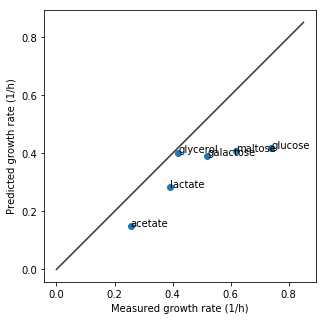

In [233]:
df_val = pd.merge(df_me, df_meas, on='ex_rxn')
xymax = max(df_val.growth_rate_1_h.max(), df_val.muopt.max())
plt.plot([0, xymax*1.15], [0, xymax*1.15], color='#333333')
plt.scatter(df_val.growth_rate_1_h, df_val.muopt)
#for k in substrates:
for i,r in df_val.iterrows():
    x = r['growth_rate_1_h']
    y = r['muopt']
    k = r['substrate']
    ls = plt.text(x, y, k)
ax = ls.axes
ax.set_aspect(1)
ax.figure.set_size_inches(5,5)
ax.set_xlabel('Measured growth rate (1/h)')
ax.set_ylabel('Predicted growth rate (1/h)')
# ax.set_xlabel('Measured rank')
# ax.set_ylabel('Predicted rank')

r,p = stats.pearsonr(df_val.growth_rate_1_h, df_val.muopt)
print 'Pearson r=%g (p=%g)' % (r,p)
r,p = stats.spearmanr(df_val.growth_rate_1_h, df_val.muopt)
print 'Spearman r=%g (p=%g)' % (r,p)
#r,p = stats.pearsonr(r_meas, r_pred)
#print 'r=%g (p=%g)' % (r,p)